In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from xgboost import XGBRegressor


from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.feature_selection import mutual_info_classif

In [99]:
rs = 42
models = [LinearRegression(), 
          DecisionTreeRegressor(random_state=rs), 
          RandomForestRegressor(random_state=rs), 
          SVC(random_state=rs), 
          XGBRegressor()]

In [130]:
def find_week(date, count_from=pd.to_datetime('2021-10-04')):
    return (pd.to_datetime(date) - count_from).days//7

def create_week(row):
    row.Week = find_week(row['DateID'])
    return row

def calc_week_val(row):
    Week = {'w1':19, 'w2':20, 'w3':21, 'w4':22}
    row.Week = Week[row['Week']]
    return row

def calc_week_test(row):
    Week = {'w1':23, 'w2':24, 'w3':25, 'w4':26}
    row.Week = Week[row['Week']]
    return row

def make_mi_scores(X, y):
    discrete_features = X.dtypes == int
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=rs)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    plt.figure(dpi=100, figsize=(8, 5))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
def MAPE_score(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

def evaluate_for_models(models, X, y):
    results = pd.DataFrame({'Model': [], 'Score Mean': [], 'Score Standard Deviation': []})
    for model in models:
        score = cross_val_score(model, X, y, 
                                scoring=make_scorer(MAPE_score))
        new_result = {'Model': model.__class__.__name__, 'Score Mean': score.mean(), 'Score Standard Deviation': score.std()}
        results = results.append(new_result, ignore_index=True)
    return results

In [101]:
train_data_path = '../data-storm-30/train_data.csv'
val_data_path = '../data-storm-30/validation_data.csv'
test_data_path = '../data-storm-30/test_data.csv'

In [102]:
train_df = pd.read_csv(train_data_path)
val_df = pd.read_csv(val_data_path)
test_df = pd.read_csv(test_data_path)

In [103]:
train_df.head()

CategoryCode  ItemCode      DateID  DailySales
0   category_2    117610   11/6/2021           7
1   category_4    836584  11/18/2021          16
2   category_1    370195   1/24/2022           6
3   category_2    172582  10/30/2021           5
4   category_2   1006009  10/30/2021           5

In [104]:
val_df.head()

CategoryCode  ItemCode Week  WeeklySales
0   category_2   1044502   w1           11
1   category_2   1105009   w1           11
2   category_2    913561   w4            5
3   category_1   1048975   w4           30
4   category_1     17287   w2           60

In [105]:
test_df.head()

CategoryCode  ItemCode Week  PredictedSales
0   category_1     43738   w4             NaN
1   category_2   1006090   w1             NaN
2   category_2   1076929   w4             NaN
3   category_1   1081321   w3             NaN
4   category_2    216151   w4             NaN

In [106]:
print(train_df.shape)
train_df.info()

(19921, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19921 entries, 0 to 19920
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CategoryCode  19921 non-null  object
 1   ItemCode      19921 non-null  int64 
 2   DateID        19921 non-null  object
 3   DailySales    19921 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 622.7+ KB


In [107]:
train_df.isnull().sum()

CategoryCode    0
ItemCode        0
DateID          0
DailySales      0
dtype: int64

category_2    9203
category_1    6841
category_3    2360
category_4    1517
Name: CategoryCode, dtype: int64


<AxesSubplot:xlabel='CategoryCode', ylabel='count'>

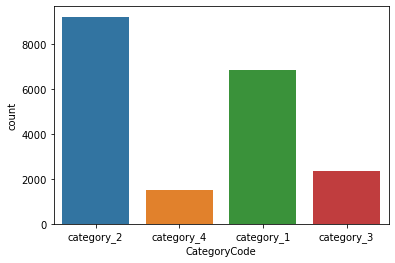

In [108]:
print(train_df.CategoryCode.value_counts())
sns.countplot(x=train_df.CategoryCode)

In [109]:
print(train_df.ItemCode.value_counts())

20824      136
132028     136
245581     136
17296      136
119554     136
          ... 
1090114     63
1068883     62
1090303     62
1090294     59
1015621     58
Name: ItemCode, Length: 194, dtype: int64


In [110]:
train_df.DailySales.describe()

count    19921.000000
mean         7.351890
std         14.605342
min          1.000000
25%          2.000000
50%          3.000000
75%          7.000000
max        434.000000
Name: DailySales, dtype: float64

In [111]:
data = pd.read_csv(train_data_path, index_col="DateID", parse_dates=True).sort_index().drop(columns=['ItemCode'])
data = pd.DataFrame(data.groupby(['CategoryCode', 'DateID']).DailySales.sum())
data

DailySales
CategoryCode DateID                
category_1   2021-10-01         698
             2021-10-02         297
             2021-10-03         246
             2021-10-04         219
             2021-10-05         173
...                             ...
category_4   2022-02-09         133
             2022-02-10         275
             2022-02-11         310
             2022-02-12         128
             2022-02-13         280

[544 rows x 1 columns]

In [112]:
def plt_dailySales(c):
    plt.figure(figsize=(14,6))
    plt.title("DailySales of " + c)
    sns.lineplot(data=data.loc[pd.IndexSlice[c,:],:], x='DateID', y='DailySales')
    plt.show()

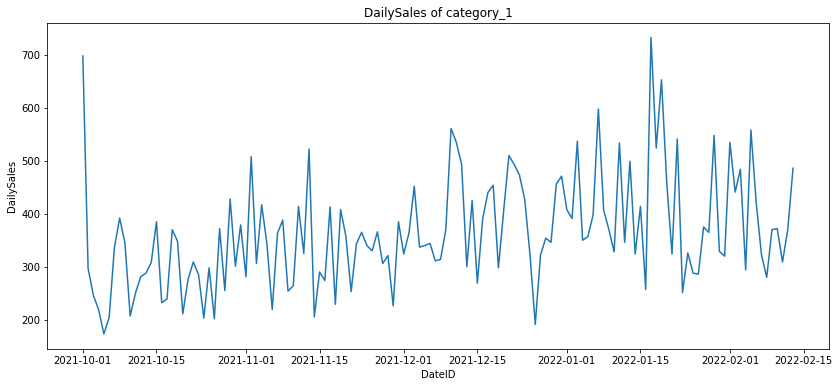

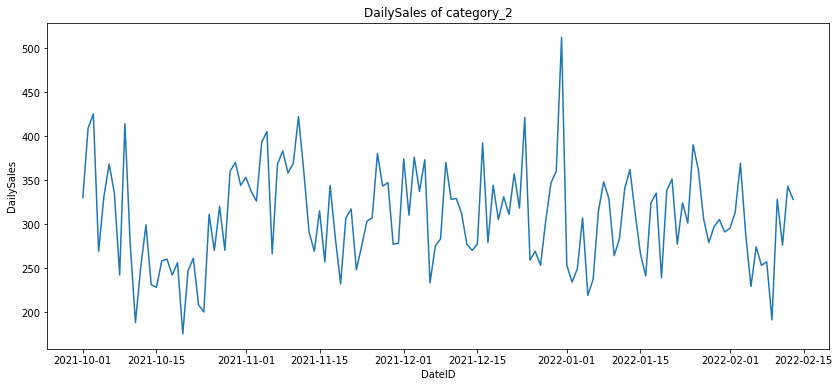

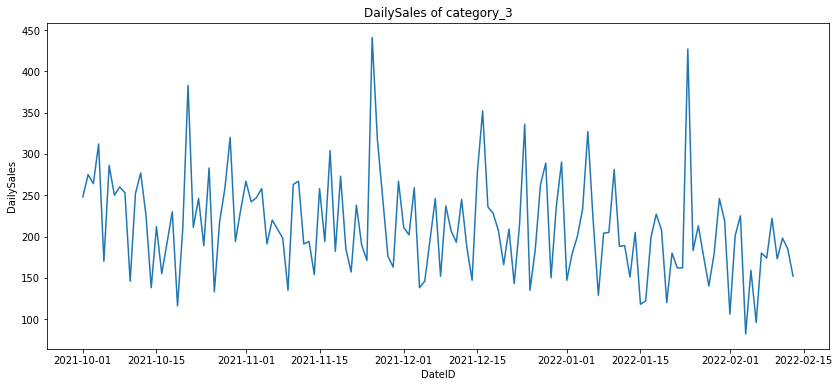

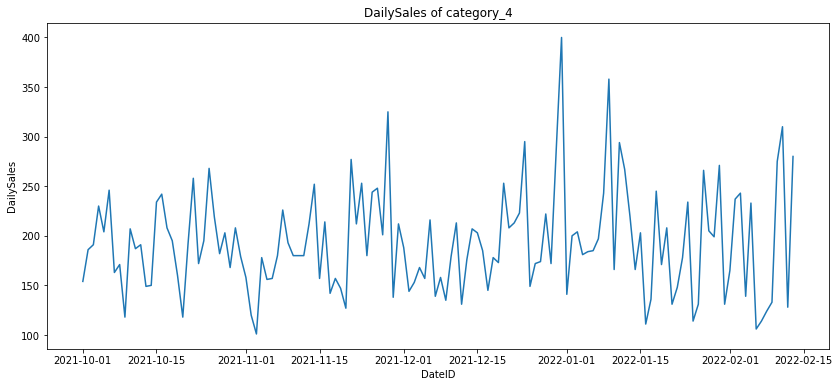

In [113]:
for i in range(1, 5):
    plt_dailySales('category_' + str(i))

In [114]:
train_df['Week'] = np.nan
week_sorted_train = train_df.apply(create_week, axis='columns')
week_sorted_train.sort_values('Week')

CategoryCode  ItemCode     DateID  DailySales  Week
17704   category_2    225259  10/2/2021           3    -1
2641    category_2      9925  10/3/2021           1    -1
2639    category_1     86992  10/3/2021           1    -1
8699    category_3   1081078  10/1/2021           3    -1
8698    category_2    132028  10/1/2021          26    -1
...            ...       ...        ...         ...   ...
6460    category_2     43630  2/11/2022           8    18
12028   category_1   1075651  2/13/2022           2    18
1947    category_1    145330   2/9/2022           1    18
10521   category_1      3427  2/13/2022           1    18
1559    category_1     37510   2/8/2022           1    18

[19921 rows x 5 columns]

In [115]:
week_sorted_train.drop(columns=['DateID'], inplace=True)

In [116]:
df = pd.DataFrame(week_sorted_train.groupby(['CategoryCode', 'ItemCode', 'Week']).DailySales.sum())
df

DailySales
CategoryCode ItemCode Week            
category_1   3418     -1            29
                       0            42
                       1            41
                       2            41
                       3            44
...                                ...
category_4   1082743   13           24
                       14            9
                       15           75
                       16           60
                       18           83

[3772 rows x 1 columns]

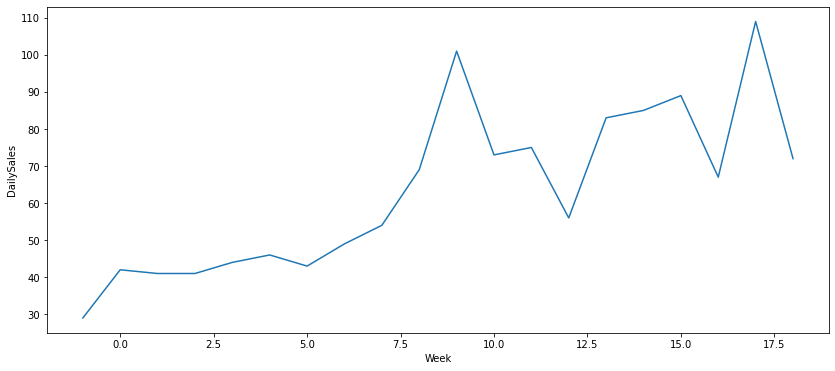

In [117]:
plt.figure(figsize=(14,6))
sns.lineplot(data=df.loc[pd.IndexSlice['category_1', 3418, :], :], x='Week', y='DailySales')
plt.show()

In [118]:
df = df.reset_index()
df = df.loc[df.Week != -1]
df.rename(columns={'DailySales': 'WeeklySales'}, inplace=True)
df

CategoryCode  ItemCode  Week  WeeklySales
1      category_1      3418     0           42
2      category_1      3418     1           41
3      category_1      3418     2           41
4      category_1      3418     3           44
5      category_1      3418     4           46
...           ...       ...   ...          ...
3767   category_4   1082743    13           24
3768   category_4   1082743    14            9
3769   category_4   1082743    15           75
3770   category_4   1082743    16           60
3771   category_4   1082743    18           83

[3593 rows x 4 columns]

In [119]:
enocoded_df = pd.get_dummies(df, prefix='C', columns=['CategoryCode'])
enocoded_df

ItemCode  Week  WeeklySales  C_category_1  C_category_2  C_category_3  \
1         3418     0           42             1             0             0   
2         3418     1           41             1             0             0   
3         3418     2           41             1             0             0   
4         3418     3           44             1             0             0   
5         3418     4           46             1             0             0   
...        ...   ...          ...           ...           ...           ...   
3767   1082743    13           24             0             0             0   
3768   1082743    14            9             0             0             0   
3769   1082743    15           75             0             0             0   
3770   1082743    16           60             0             0             0   
3771   1082743    18           83             0             0             0   

      C_category_4  
1                0  
2                0  
3                0  
4                0  
5                0  
...            ...  
3767             1  
3768             1  
3769             1  
3770             1  
3771             1  

[3593 rows x 7 columns]

In [120]:
X = enocoded_df.drop(columns=['WeeklySales'])
y = enocoded_df.WeeklySales

ItemCode        1.876764
Week            0.419562
C_category_2    0.051469
C_category_1    0.015403
C_category_3    0.005481
C_category_4    0.000000
Name: MI Scores, dtype: float64


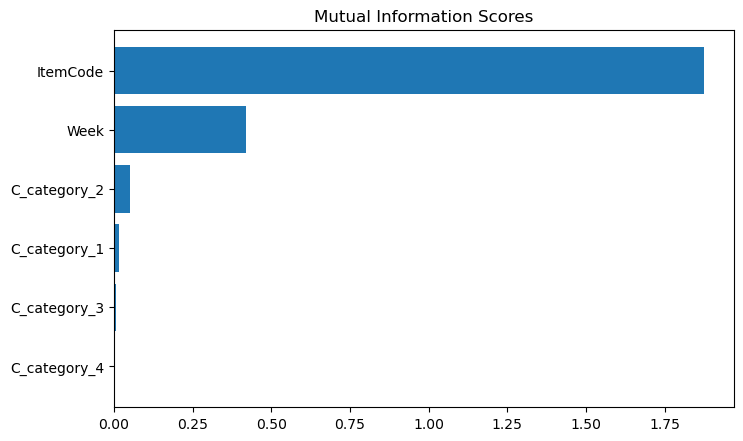

In [121]:
mi = make_mi_scores(X, y)
print(mi)
plot_mi_scores(mi)

In [122]:
evaluate_for_models(models, X, y)

/home/kajanan/ProgramFiles/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Model  Score Mean  Score Standard Deviation
0       LinearRegression    2.290267                  1.066484
1  DecisionTreeRegressor    2.026641                  1.513406
2  RandomForestRegressor    3.360605                  3.546447
3                    SVC    0.696217                  0.030081
4           XGBRegressor    3.080216                  2.256830

In [123]:
category_dropped_df = df.drop(columns=['CategoryCode'])
category_dropped_df

ItemCode  Week  WeeklySales
1         3418     0           42
2         3418     1           41
3         3418     2           41
4         3418     3           44
5         3418     4           46
...        ...   ...          ...
3767   1082743    13           24
3768   1082743    14            9
3769   1082743    15           75
3770   1082743    16           60
3771   1082743    18           83

[3593 rows x 3 columns]

In [124]:
X = category_dropped_df.drop(columns=['WeeklySales'])
y = category_dropped_df.WeeklySales

In [125]:
evaluate_for_models(models, X, y)

/home/kajanan/ProgramFiles/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Model  Score Mean  Score Standard Deviation
0       LinearRegression    2.845759                  1.233334
1  DecisionTreeRegressor    3.879088                  2.234564
2  RandomForestRegressor    3.856778                  2.238932
3                    SVC    0.697421                  0.028285
4           XGBRegressor    3.853467                  2.255122

In [126]:
model = SVC(random_state=rs)
model.fit(X, y)

SVC(random_state=42)

In [127]:
week_modified_val = val_df.apply(calc_week_val, axis='columns')
week_modified_val

CategoryCode  ItemCode  Week  WeeklySales
0     category_2   1044502    19           11
1     category_2   1105009    19           11
2     category_2    913561    22            5
3     category_1   1048975    22           30
4     category_1     17287    20           60
..           ...       ...   ...          ...
365   category_2    124954    20           43
366   category_2     40759    19           48
367   category_1   1090303    19           19
368   category_2   1090276    21            6
369   category_1      3418    22           69

[370 rows x 4 columns]

In [128]:
X = week_modified_val.drop(columns=['WeeklySales', 'CategoryCode'])
y_true = week_modified_val.WeeklySales
y_pred = model.predict(X)
mean_absolute_percentage_error(y_true, y_pred)

0.7247842576213573

In [129]:
#try to do test for all model rather than doing only for svm
#tunning
#bagging or votting
#train+val
#fit
#crossval
#test
#submit